In [1]:
import pandas as pd
import numpy as np
from scipy import signal
from scipy import stats
from matplotlib import mlab
import matplotlib.pyplot as plt
from statsmodels.tsa.vector_ar.var_model import VAR

In [2]:
mobile_PATH = '/home/is/shuntaro-o/dev/compare_population_and_tweet_number/data/mobile/Tokyostation/Tokyostation_2021.npy'
twitter_PATH = '/home/is/shuntaro-o/dev/compare_population_and_tweet_number/data/twitter/Tokyostation_2021/Tokyostation_3zi_2021.npy'
outlier_twitter__PATH = '/home/is/shuntaro-o/dev/compare_population_and_tweet_number/data/twitter/Tokyostation_2021/outlier/Tokyostation_3zi_2021.npy'

mobile = np.load(mobile_PATH)
twitter = np.load(twitter_PATH)
mobile_flatten = mobile.flatten()
twitter_flatten = twitter.flatten()

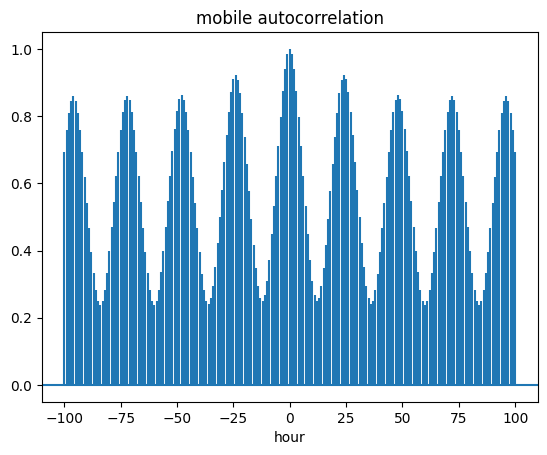

In [3]:
plt.acorr(mobile_flatten.astype('f'), detrend=mlab.detrend_none, maxlags=100)
plt.xlabel('hour')
plt.title('mobile autocorrelation')
plt.show()

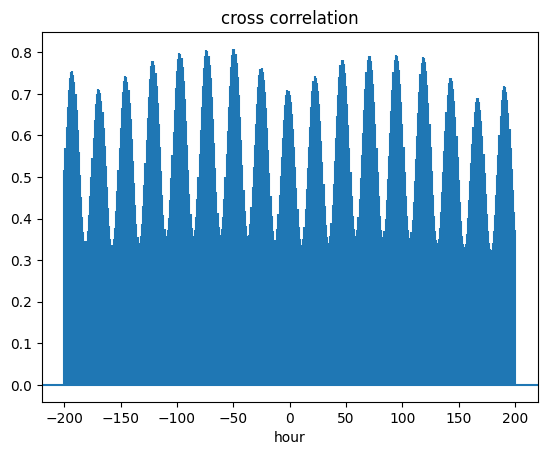

In [9]:
# 相互相関コレログラム（原系列）
plt.xcorr(mobile_flatten.astype('f'), twitter_flatten.astype('f'),detrend=mlab.detrend_none, maxlags=200)
plt.xlabel('hour')
plt.title('cross correlation')
plt.show()

In [5]:
mobile_flatten

array([ 5509,  5315,  5261, ..., 14185, 11374,  9310])

In [6]:
x = np.stack([mobile_flatten, twitter_flatten]).T

In [10]:
x

array([[ 5509,    11],
       [ 5315,     2],
       [ 5261,     0],
       ...,
       [14185,    20],
       [11374,    15],
       [ 9310,    12]])

In [14]:
df = pd.DataFrame(x, columns=['mobile', 'twitter'])

In [15]:
df

,mobile,twitter
0,5509,11
1,5315,2
2,5261,0
3,5197,2
4,5172,1
...,...,...
8755,20956,29
8756,17201,25
8757,14185,20
8758,11374,15


In [16]:
maxlags = 200
# モデルのインスタンス生成
model = VAR(df)
# 最適なラグの探索
lag = model.select_order(maxlags).selected_orders
print('最適なラグ：',lag['aic'],'\n')
# モデルの学習
results = model.fit(lag['aic'])
print(results.summary())

最適なラグ： 196 

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 28, Apr, 2023
Time:                     16:54:34
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    18.6237
Nobs:                     8564.00    HQIC:                   18.1970
Log likelihood:          -100491.    FPE:                6.41187e+07
AIC:                      17.9761    Det(Omega_mle):     5.86155e+07
--------------------------------------------------------------------
Results for equation mobile
                  coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------
const              289.263237       109.946547            2.631           0.009
L1.mobile            1.955701         0.011054          176.930           0.000
L1.twitter          -8.698515         3.160797    

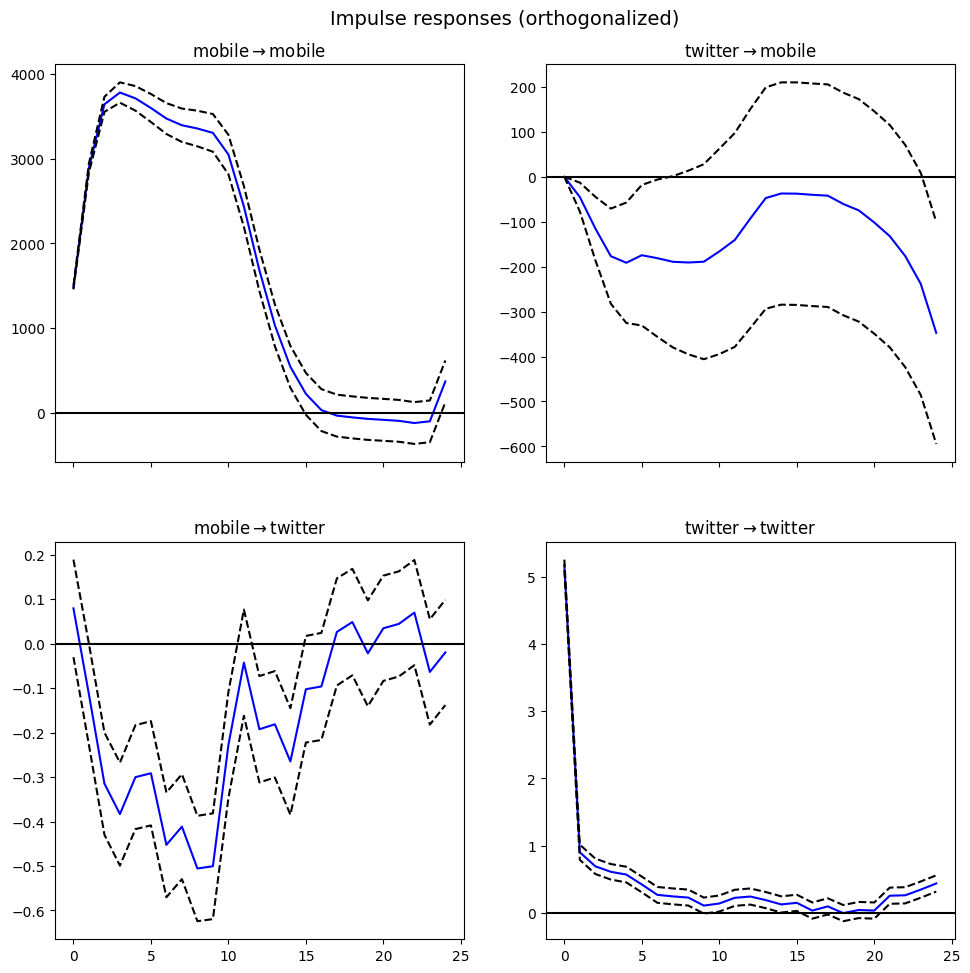

In [17]:
# (直行化)インパルス応答関数
period = 24
irf = results.irf(period)
irf.plot(orth=True)
plt.show()

In [20]:
sigma = results.sigma_u
L = np.linalg.cholesky(sigma)
L_inv = np.linalg.inv(L)
L_t_inv = np.linalg.inv(L.T)
D = L_inv * sigma * L_t_inv

new_sigma_sqrt = np.sqrt(np.diag(D))
new_sigma_sqrt

array([1.        , 1.00011715])